## Python Modules

In [62]:
import os
import pandas as pd
import numpy as np
import pickle

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series

In [5]:
directorio_actual = os.getcwd()
data_ts           = os.path.join(directorio_actual, 'data', 'processed', 'data_over_time_ds.pickle')

with open(data_ts, 'rb') as f:
    data_over_time_ds = pickle.load(f)

In [6]:
data_over_time_ds[0].head()

,date,frequency
0,2021-10-31 04:24:22.860,0.005138
1,2021-12-05 03:57:27.500,0.015413
2,2022-01-08 07:49:55.000,0.005138
3,2022-02-11 11:42:22.500,0.015413
4,2022-03-17 15:34:50.000,0.005138


### Handle Missings

In [10]:
# Índices de los tópicos a analizar
topics = [2, 6, 7]
df_ts_resultado = []

for i, df_topic in enumerate(data_over_time_ds):
    if i not in topics:
        continue

    df_topic['date'] = pd.to_datetime(df_topic['date']).dt.floor('D')
    fecha_minima = df_topic['date'].min()
    fecha_maxima = df_topic['date'].max()
    
    todas_fechas = pd.date_range(start=fecha_minima, end=fecha_maxima, freq='D')
    df_todas_fechas = pd.DataFrame({'date': todas_fechas})
    
    df_resultado = pd.merge(df_todas_fechas, df_topic, on='date', how='left')
    df_resultado['frequency'] = df_resultado['frequency'].interpolate(method='linear')
    
    df_ts_resultado.append(df_resultado)

    fig = px.line(df_resultado, x='date', y='frequency', title=f'Topic {i} over time')
    fig.show()

    # print(f"\n--- Topic {i} ---")
    # print(df_resultado)

## Breakpoints

21:19:15 - cmdstanpy - INFO - Chain [1] start processing



 Analizando Tópico 0


21:19:15 - cmdstanpy - INFO - Chain [1] done processing


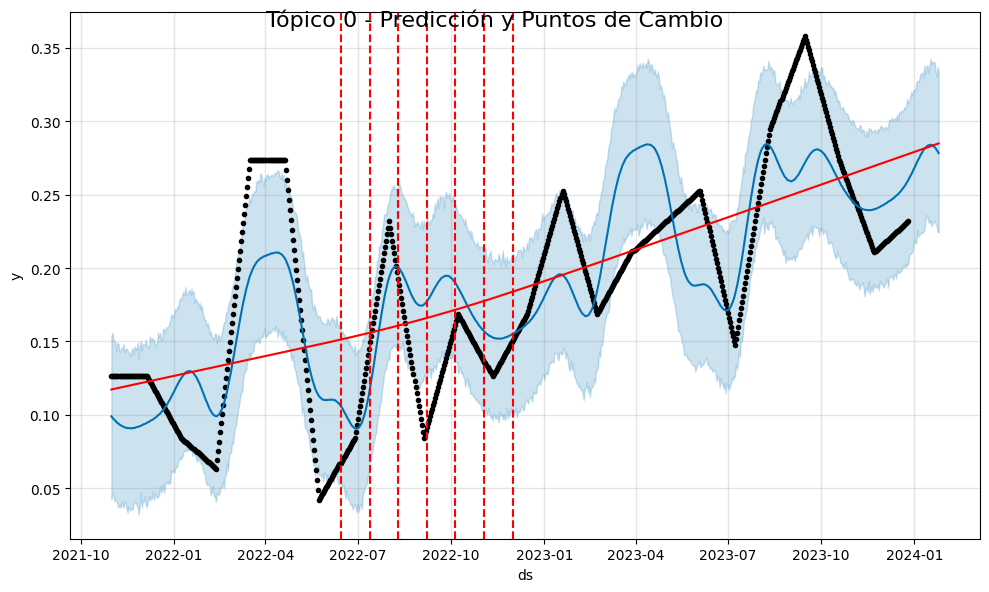

21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:16 - cmdstanpy - INFO - Chain [1] done processing



 Analizando Tópico 1


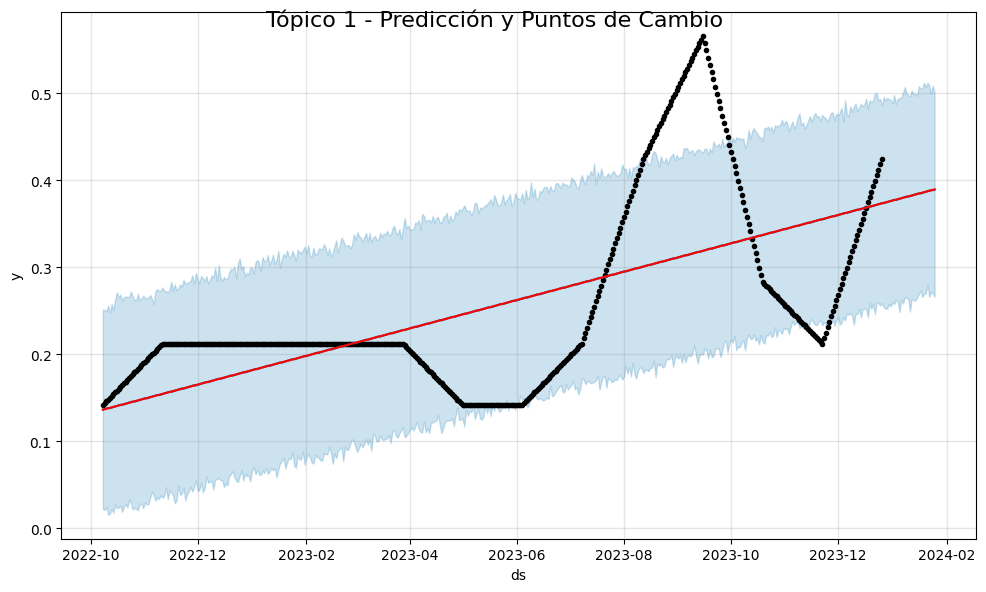


 Analizando Tópico 2


21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:16 - cmdstanpy - INFO - Chain [1] done processing


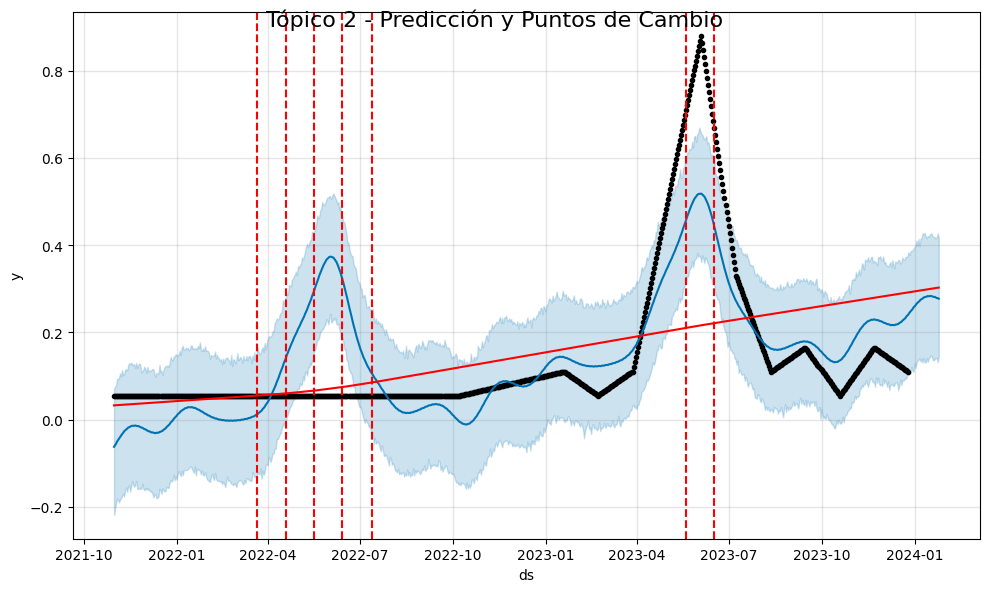

In [ ]:

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# Tópicos a analizar
topics = [0, 1, 2]

for idx in topics:
    print(f"\n Analizando Tópico {idx}")
    
    df_resultado = df_ts_resultado[idx].copy()
    df_t = df_resultado.rename(columns={'date': 'ds', 'frequency': 'y'})

    # Modelo Prophet con parámetros más restrictivos
    m = Prophet(
        changepoint_range=0.9,           # Menor rango donde buscar puntos de cambio
        changepoint_prior_scale=0.01,    # Menor sensibilidad: detecta solo cambios fuertes
        seasonality_prior_scale=1.0      # Reduzco influencia de estacionalidad
    )
    m.fit(df_t)

    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)

    fig = m.plot(forecast)
    fig.suptitle(f"Tópico {idx} - Predicción y Puntos de Cambio", fontsize=16)
    add_changepoints_to_plot(fig.gca(), m, forecast)
    plt.show()

    changepoint_dates = m.changepoints
    valores = df_t[df_t['ds'].isin(changepoint_dates)][['ds', 'y']]
    # print(valores)

    fig2 = px.line(df_resultado, x='date', y='frequency',
                   title=f'Tópico {idx} - Serie Original con Changepoints')
    fig2.add_scatter(
        x=valores['ds'], y=valores['y'],
        mode='markers',
        marker=dict(color='red', size=8),
        name='Changepoints'
    )
    fig2.show()



 Analizando rupturas en Tópico 0

 Fechas detectadas:
DatetimeIndex(['2021-12-24', '2022-02-22', '2022-03-09', '2022-04-28',
               '2022-05-13', '2022-07-02', '2022-12-19', '2023-08-06',
               '2023-10-20', '2023-12-26'],
              dtype='datetime64[ns]', freq=None)


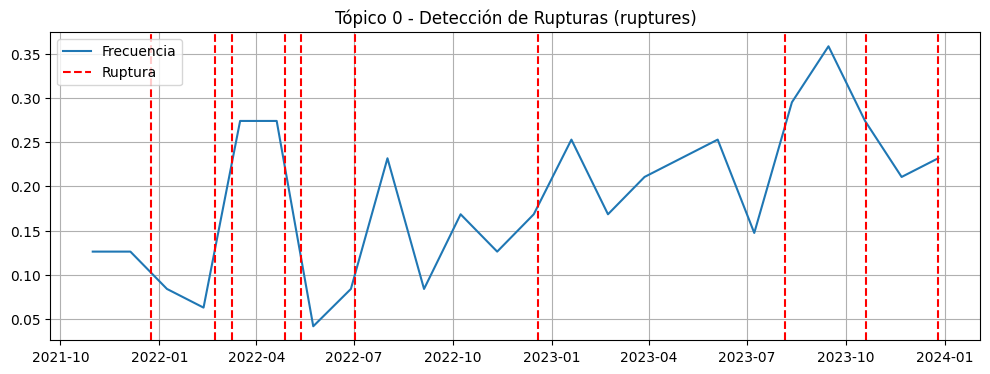


 Analizando rupturas en Tópico 1

 Fechas detectadas:
DatetimeIndex(['2022-11-01', '2023-04-15', '2023-06-19', '2023-07-14',
               '2023-08-03', '2023-08-23', '2023-09-27', '2023-10-12',
               '2023-12-06', '2023-12-26'],
              dtype='datetime64[ns]', freq=None)


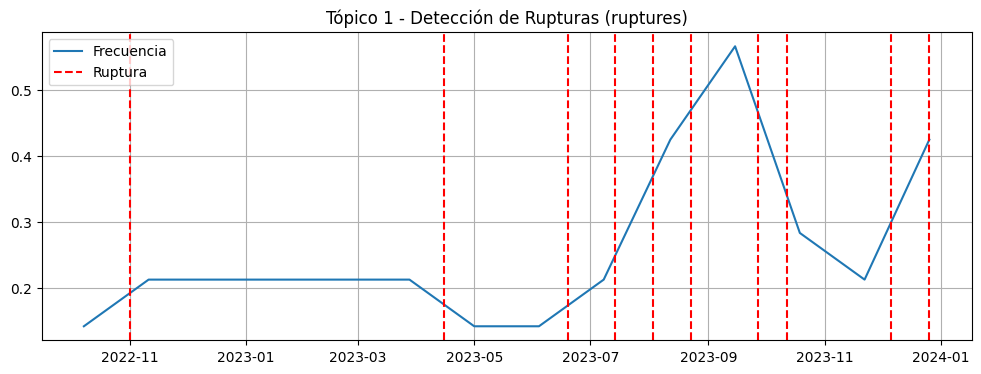

In [44]:
topics = [0, 1]
n_breaks = 10

for idx in topics:
    print(f"\n Analizando rupturas en Tópico {idx}")
    
    df_test = df_ts_resultado[idx].copy()
    df_test['date'] = pd.to_datetime(df_test['date'])
    df_test.set_index('date', inplace=True)

    ts = df_test['frequency'].copy()
    y = np.array(ts.tolist())

    # Modelo ruptures
    model = rpt.Dynp(model="l1").fit(y)
    breaks = model.predict(n_bkps=n_breaks - 1)

    # Obtener fechas reales
    breaks_rpt = [ts.index[i - 1] for i in breaks]
    breaks_rpt = pd.to_datetime(breaks_rpt)
    print("\n Fechas detectadas:")
    print(breaks_rpt)

    # Visualización
    plt.figure(figsize=(12, 4))
    plt.plot(ts, label='Frecuencia')
    for i, break_date in enumerate(breaks_rpt):
        if i == 0:
            plt.axvline(break_date, color='red', linestyle='--', label='Ruptura')
        else:
            plt.axvline(break_date, color='red', linestyle='--')
    plt.title(f'Tópico {idx} - Detección de Rupturas (ruptures)')
    plt.legend()
    plt.grid()
    plt.show()


 Tópico 0 - Detección con modelo Window (l2)


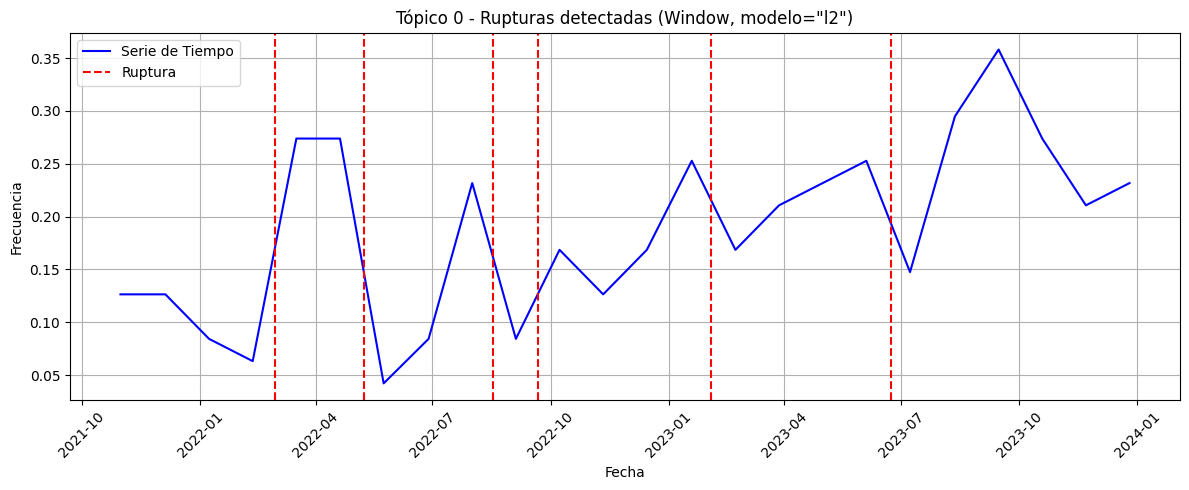


 Fechas detectadas:
  - 2022-02-28
  - 2022-05-09
  - 2022-08-17
  - 2022-09-21
  - 2023-02-03
  - 2023-06-23

 Tópico 1 - Detección con modelo Window (l2)


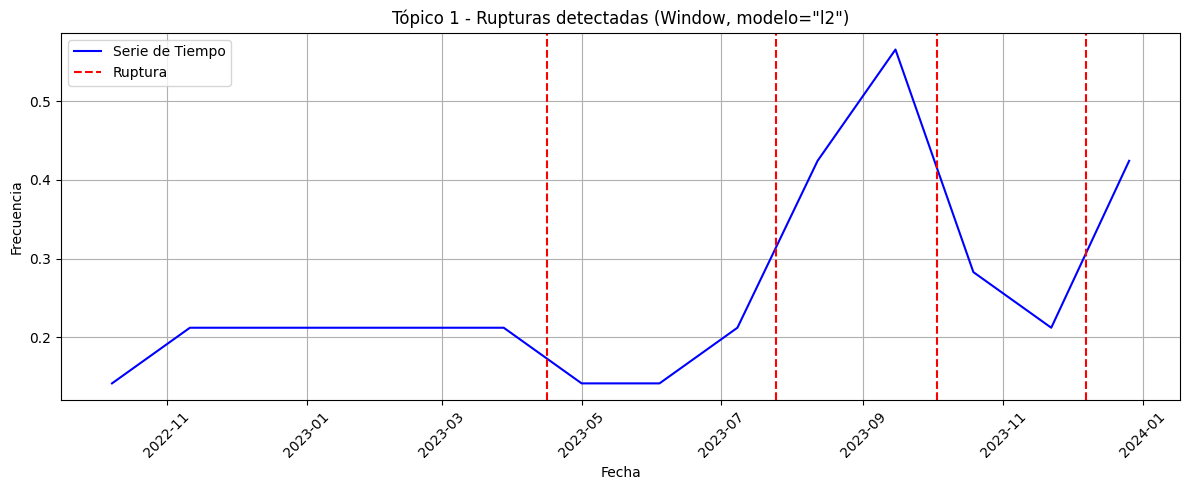


 Fechas detectadas:
  - 2023-04-16
  - 2023-07-25
  - 2023-10-03
  - 2023-12-07


In [46]:
from ruptures.detection import Window

# Parámetros globales
topics = [0, 1]        # Índices de tópicos a analizar
model = "l2"              # También puedes probar: 'l1', 'rbf', 'normal'
window_width = 30         # Tamaño de la ventana
n_bkps = 6                # Número de rupturas a detectar

for idx in topics:
    print(f"\n Tópico {idx} - Detección con modelo Window ({model})")

    # Preparar la serie
    df_tst = df_ts_resultado[idx].copy()
    increase_data = np.array(df_tst['frequency'].to_list())
    time_index = pd.to_datetime(df_tst['date'].to_list())

    # Aplicar modelo de rupturas
    algo = Window(width=window_width, model=model).fit(increase_data)
    my_bkps = algo.predict(n_bkps=n_bkps)

    # Visualización
    plt.figure(figsize=(12, 5))
    plt.plot(time_index, increase_data, label='Serie de Tiempo', color='blue')
    
    for i, bk in enumerate(my_bkps):
        if bk < len(time_index):
            if i == 0:
                plt.axvline(time_index[bk], color='red', linestyle='--', label='Ruptura')
            else:
                plt.axvline(time_index[bk], color='red', linestyle='--')

    plt.title(f'Tópico {idx} - Rupturas detectadas (Window, modelo="{model}")')
    plt.xlabel('Fecha')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Imprimir fechas de ruptura
    rupt_dates = [time_index[bk] for bk in my_bkps if bk < len(time_index)]
    print("\n Fechas detectadas:")
    for fecha in rupt_dates:
        print("  -", fecha.strftime("%Y-%m-%d"))


 Tópico 0 - Detección de cambio en ventana [2023-04-01 - 2023-10-30]


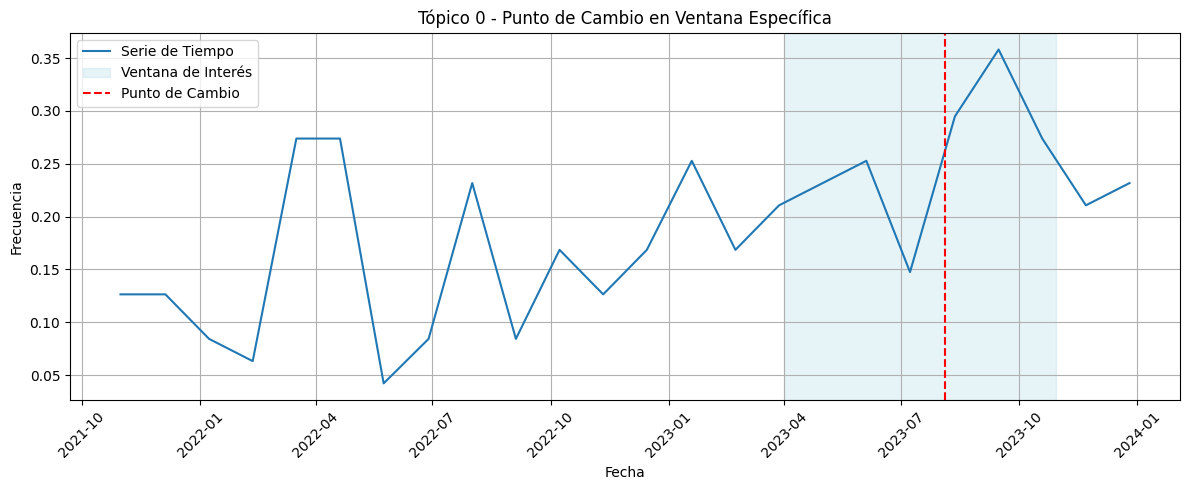


 Fecha(s) detectada(s):
  - 2023-08-04

 Tópico 1 - Detección de cambio en ventana [2023-04-01 - 2023-10-30]


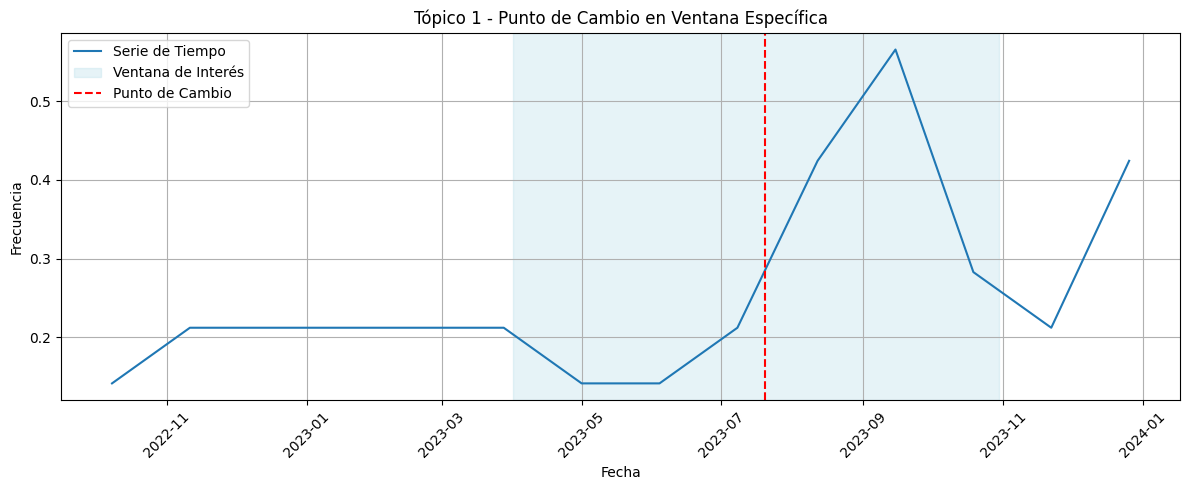


 Fecha(s) detectada(s):
  - 2023-07-20

 Tópico 2 - Detección de cambio en ventana [2023-04-01 - 2023-10-30]


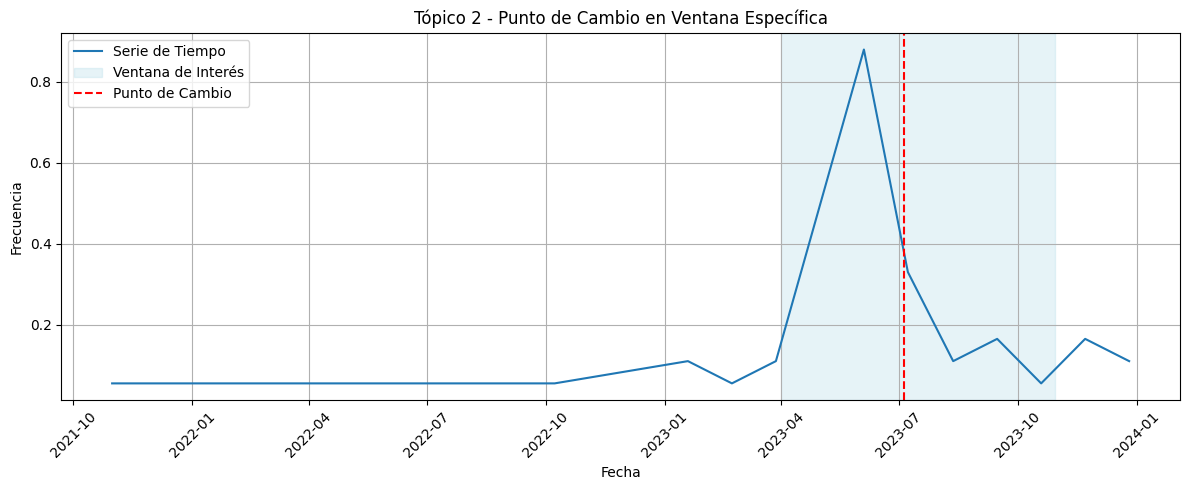


 Fecha(s) detectada(s):
  - 2023-07-05


In [47]:
from ruptures.detection import Binseg

topics = [0, 1 ,2] 

# Ventana de interés
start_date = pd.Timestamp('2023-04-01')
end_date = pd.Timestamp('2023-10-30')

for idx in topics:
    print(f"\n Tópico {idx} - Detección de cambio en ventana [{start_date.date()} - {end_date.date()}]")

    df_tst = df_ts_resultado[idx].copy()
    df_tst['date'] = pd.to_datetime(df_tst['date'])
    ts_data = pd.Series(df_tst['frequency'].to_list(), index=df_tst['date'])

    # Filtrar por ventana
    ts_interest = ts_data.loc[(ts_data.index >= start_date) & (ts_data.index <= end_date)]

    # Detectar con Binseg
    algo = Binseg().fit(ts_interest.values.reshape(-1, 1))
    result = algo.predict(n_bkps=1)

    changepoints = result[:-1]  # Excluye el final artificial
    rupture_dates = [ts_interest.index[i] for i in changepoints]

    # Mostrar resultados
    plt.figure(figsize=(12, 5))
    plt.plot(ts_data.index, ts_data, label='Serie de Tiempo')
    plt.axvspan(start_date, end_date, color='lightblue', alpha=0.3, label='Ventana de Interés')

    for i, cp_date in enumerate(rupture_dates):
        plt.axvline(cp_date, color='red', linestyle='--', label='Punto de Cambio' if i == 0 else None)

    plt.title(f'Tópico {idx} - Punto de Cambio en Ventana Específica')
    plt.xlabel('Fecha')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\n Fecha(s) detectada(s):")
    for fecha in rupture_dates:
        print("  -", fecha.strftime("%Y-%m-%d"))

In [ ]:
### from ruptures.metrics import precision_recall

## LTSM

In [55]:
train_size = int(0.85 * len(df_resultado))
test_size  = len(df_resultado) - train_size

univariate_df = df_resultado[['date', 'frequency']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

668 119


In [56]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values
#scaler = MinMaxScaler(feature_range=(-1, 0))
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

#scaled_data[:10]

In [57]:
# Defines the rolling window
#52
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

564 119


In [58]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5


c:\Users\Alexis\Documents\Python\weak_signals_final\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



564/564 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0091 - val_loss: 0.0027
Epoch 2/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1828e-04 - val_loss: 0.0010
Epoch 4/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0023 - val_loss: 7.2139e-04
Epoch 5/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.9284e-04 - val_loss: 0.0011


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,195 (1.64 MB)

 Trainable params: 143,731 (561.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 287,464 (1.10 MB)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print('RMSE: {}'.format(score_rmse))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
RMSE: 0.027174285755463722


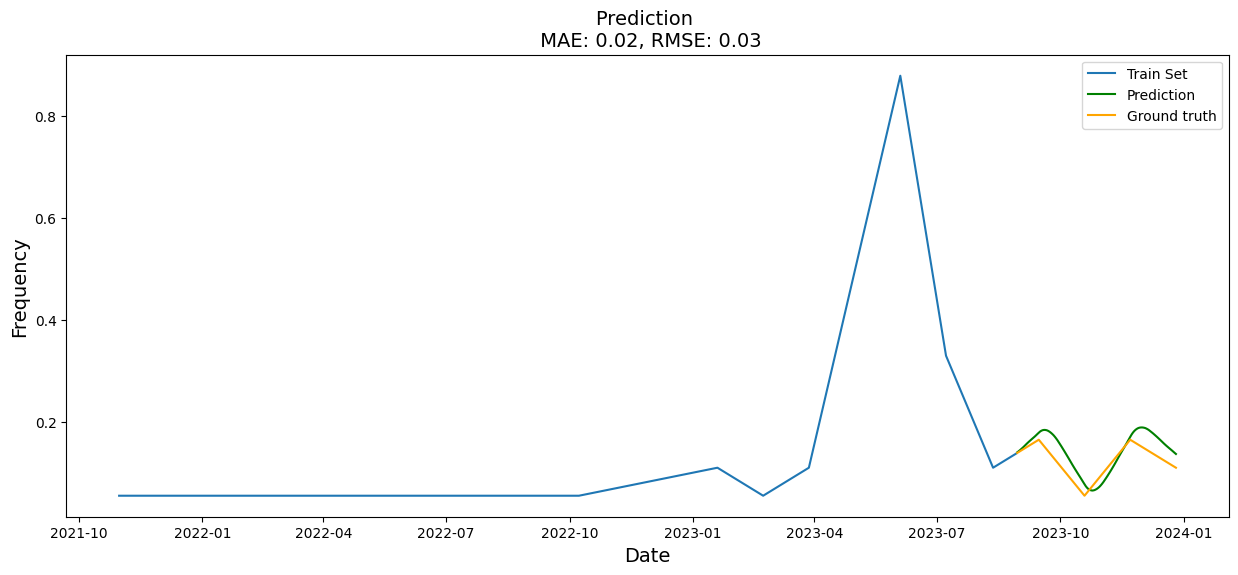

In [63]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Frequency', fontsize=14)

plt.show()